In [1]:
# MATH 7243 Project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import statsmodels.api as sm

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import tensorflow as tf
import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks

2023-04-22 16:03:02.585462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

col2020 = ['LU', 'ZIPCODE', 'MAIL_ZIPCODE', 'AV_LAND', 'AV_BLDG', 'AV_TOTAL',
           'GROSS_TAX', 'LAND_SF', 'YR_BUILT', 'R_BLDG_STYL',
           'R_TOTAL_RMS', 'R_BDRMS', 'R_HEAT_TYP','R_AC', 'R_EXT_CND', 
           'R_INT_CND']

col2122 = ['LU', 'ZIPCODE', 'MAIL_ZIPCODE', 'LAND_VALUE', 'BLDG_VALUE', 
           'TOTAL_VALUE','GROSS_TAX', 'LAND_SF', 'YR_BUILT', 'BLDG_TYPE', 
           'TT_RMS', 'BED_RMS', 'HEAT_TYPE','AC_TYPE', 'EXT_COND', 'INT_COND']

CHARACTER = '''
The potential renter will be a 20-22 year old college student from Northeastern University. 

According to Ziprecruiter, the average annual pay for the Student jobs category 
in Boston is $54,845 a year, or $4,570 per month, and the average living expenses 
for a student who lives off-campus is $2843 per month. With the information 
above, an average student would be able to pay a maximum of $1,727  for housing. 


The potential renter will have a budget of $1730/mo., with 2 roommates with 
similar budgets. Overall, they have a rent cap of $5200/mo. for a 3 bedroom apartment.  
No one in the apartment has a car, so no need for parking, but also would prefer 
to be within walking distance of Northeastern or along the T line. '''

In [3]:
def removeobj(objectlst, daf):
    
    for element in objectlst:
        daf[element] = daf[element].astype('string')
        column = daf[element]
        cleancol = []
        for cell in column:
            if ',' in cell:
                cell = cell.strip('$').split(',')
            else: cell = cell.strip('$')
            if len(cell) == 2:
                cell = str(cell[0] + cell[1])
            elif len(cell) >= 3:
                cell = str(cell[0] + cell[1] + cell[2])
            cleancol.append(cell)
        daf[element] = pd.DataFrame(cleancol)
        daf[element] = daf[element].astype('float64')

    daf = daf.select_dtypes(include=['int64','float64'])
    
    return daf

In [4]:
def zipdrop(df):
    
    df1 = df[df['ZIPCODE'] == 2115.0]
    df2 = df[df['ZIPCODE'] == 2116.0]
    df3 = df[df['ZIPCODE'] == 2215.0]
    df4 = df[df['ZIPCODE'] == 2120.0]
    df5 = df[df['ZIPCODE'] == 2125.0]            
    df6 = df[df['ZIPCODE'] == 2127.0]
    df7 = df[df['ZIPCODE'] == 2108.0]            
    df8 = df[df['ZIPCODE'] == 2111.0]
    
    df_clean = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8])
    
    return df_clean

In [5]:
def dataclean():
    
    variables = ['ZIPCODE', 'AV_LAND', 'AV_BLDG', 'AV_TOTAL','GROSS_TAX', 
                 'LAND_SF', 'YR_BUILT', 'R_TOTAL_RMS', 'R_BDRMS', 'R_HEAT_TYP',
                 'R_AC', 'GROSS_AREA','LIVING_AREA']
    
    year0 = pd.read_csv('data2020-full.csv', usecols = variables)
    clean_year0 = year0.dropna(axis = 'rows')
    clean_year0 = clean_year0.select_dtypes(include=['int64','float64'])
    
    # f,ax = plt.subplots(figsize=(18, 18))
    # sns.heatmap(clean_year0.corr(),annot=True,linewidth=.5, fmt='.1f')
    # plt.show()
    
    clean_year0.insert(loc=0, column='YEAR', value= 2020)

        
    variables1 = ['ZIPCODE', 'LAND_SF', 'GROSS_AREA', 'LIVING_AREA',
                  'LAND_VALUE', 'BLDG_VALUE', 'TOTAL_VALUE', 'GROSS_TAX', 
                  'TT_RMS', 'BED_RMS']
    
    objectlst = ['LAND_VALUE', 'BLDG_VALUE', 'TOTAL_VALUE', 'GROSS_TAX']
    
    year1 = pd.read_csv('data2021-full.csv', usecols = variables1)
    clean_year1 = year1.dropna(axis = 'rows')
    clean_year1.dtypes
        
    clean_year1 = removeobj(objectlst, clean_year1)
    
    # f,ax = plt.subplots(figsize=(18, 18))
    # sns.heatmap(clean_year1.corr(),annot=True,linewidth=.5, fmt='.1f')
    # plt.show()

    clean_year1.insert(loc=0, column='YEAR', value= 2021)
    
    # cleaning 2022 data

    year2 = pd.read_csv('data2022-full.csv', usecols = variables1)
    clean_year2 = year2.dropna(axis = 'rows')
    
    clean_year2 = removeobj(objectlst, clean_year2)
    
    clean_year2 = clean_year2.select_dtypes(include=['int64','float64'])
    
    # f,ax = plt.subplots(figsize=(18, 18))
    # sns.heatmap(clean_year2.corr(),annot=True,linewidth=.5, fmt='.1f')
    # plt.show()
    
    clean_year2.insert(loc=0, column='YEAR', value= 2022)
    
    building_violation = pd.read_csv('tmp990r75gd.csv', usecols = ['status_dttm','description','violation_city', 'violation_zip','ward'])
    building_violation = building_violation.dropna(axis = 'rows')
    
    unemployment = pd.read_csv('unemployment_rate.csv')
    unemployment['YEAR'] = pd.DatetimeIndex(unemployment['DATE']).year 
    unemployment = unemployment[unemployment['YEAR'] >= 2020]
    filtered_unemployment = pd.DataFrame(unemployment.groupby('YEAR')["BOST625URN"].mean())
    filtered_unemployment
    
    index = pd.read_csv('HPI_2000_2022.csv')
    
    clean_year0 = clean_year0[['ZIPCODE', 'LAND_SF', 'GROSS_AREA', 
                               'LIVING_AREA','AV_LAND', 'AV_BLDG', 'AV_TOTAL',
                               'GROSS_TAX','R_TOTAL_RMS', 'R_BDRMS',
                               'YEAR', 'YR_BUILT' ]]
    
    del clean_year0[clean_year0. columns[-1]] 
    
    clean_year0.columns = ['ZIPCODE', 'LAND_SF', 'GROSS_AREA', 'LIVING_AREA', 
                           'LAND_VALUE','BLDG_VALUE', 'TOTAL_VALUE', 'GROSS_TAX', 
                           'BED_RMS', 'TT_RMS', 'YEAR']
    
    clean_year0 = zipdrop(clean_year0)
    clean_year1 = zipdrop(clean_year1)
    clean_year2 = zipdrop(clean_year2)
    
    bldg_assess_full = pd.concat([clean_year0,clean_year1,clean_year2])
    full_bldg_data = bldg_assess_full.merge(filtered_unemployment, how = 'left', on = 'YEAR')  
    clean_full_bldg_data = full_bldg_data.dropna(axis = 'rows').reset_index()
    return clean_full_bldg_data, filtered_unemployment, building_violation


In [6]:
def analyzecheapest(full_bldg_data):
    
    print('\n We aim to analyze the relationships between property features and price',
          'specifically in the zipcode determined to be cheapest:\n')
    
    clean_full_data = full_bldg_data.drop_duplicates()
    df = clean_full_data.reset_index()
    df['ZIPCODE'] = df['ZIPCODE'].astype(str)
    Safe_and_affordable = df[df['ZIPCODE'].isin(['2115.0'])]

    f,ax = plt.subplots(figsize=(18, 18))
    sns.heatmap(Safe_and_affordable.corr(),annot=True,linewidth=.5, fmt='.1f')
    plt.show()  
  
    print('Based on the heat map, the 3 factors that affect the total value the most',
         'are GROSS_TAX, LAND_VALUE, and BLDG_VALUE')
    
    print('Demonstrating the relationship between GROSS_TAX, LAND_VALUE, BLDG_VALUE and TOTAL_VALUE')
        
    Xa = Safe_and_affordable.drop(columns=['index', 'ZIPCODE', 
                                       'LAND_SF', 'LIVING_AREA', 'GROSS_AREA', 'BED_RMS', 'TT_RMS', 
                                       'YEAR', 'BOST625URN'])
    Y = Safe_and_affordable['TOTAL_VALUE']

    ols = sm.OLS(Y, Xa)
    ols_result = ols.fit()
    ols_result.summary()

    train_X, test_X, train_y, test_y = train_test_split(Xa, Y, test_size = 0.2, 
                                                        random_state = 42)
    regr = LinearRegression()
    model = regr.fit(train_X, train_y)
    
    print('Model fit with Linear Regression:')
    print(regr.score(test_X, test_y))
    
    pred_y = model.predict(test_X)
    MSE = metrics.mean_squared_error(test_y, pred_y)
    
    print('Mean Squared Error:', MSE)
    avgvalOLS = np.average(pred_y)

    # Ridge Regression
    
    ridge = Ridge(alpha = .09)
    model = ridge.fit(train_X, train_y)
    
    print('Model fit with Ridge Regression:')
    print(model.score(test_X, test_y))
    
    predrdg_y = model.predict(test_X)
    MSErdg = metrics.mean_squared_error(test_y, predrdg_y)
    
    print('Mean Squared Error:', MSErdg)    
    avgvalrdg = np.average(predrdg_y)

    # Lasso Regression
    
    lasso = LassoCV(cv = 3, random_state= 42)
    model = lasso.fit(train_X, train_y)
    
    print('Model fit with Lasso Regression (with CV):')
    print(model.score(test_X, test_y))
    
    predlas_y = model.predict(test_X)
    
    MSElas = metrics.mean_squared_error(test_y, predlas_y)
    
    print('Mean Squared Error:', MSElas)    
    avgvallas = np.average(predlas_y)

In [7]:
def linreg(df, X, y, zipcode):
    
    print('\n Metric Analysis for Zipcode', str('0' + str(
        round(zipcode))), '\n')
    
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)
    regr = LinearRegression()
    
    model = regr.fit(X_train, y_train)
    
    print('Model fit with Linear Regression:')
    print(regr.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    
    MSE = metrics.mean_squared_error(y_test, y_pred)
    
    print('Mean Squared Error:', MSE)
    
    avgvalOLS = np.average(y_pred)
    
    # Ridge Regression
    
    ridge = Ridge(alpha = .5)
    model = ridge.fit(X_train,y_train)
    
    print('Model fit with Ridge Regression:')
    print(model.score(X_test, y_test))
    
    y_predrdg = model.predict(X_test)
    
    MSErdg = metrics.mean_squared_error(y_test, y_predrdg)
    
    print('Mean Squared Error:', MSErdg)    
    avgvalrdg = np.average(y_predrdg)
    
    # Lasso Regression
    
    lasso = LassoCV(cv = 5, random_state= 42)
    model = lasso.fit(X_train, y_train)
    
    print('Model fit with Lasso Regression (with CV):')
    print(model.score(X_test, y_test))
    
    y_predlas = model.predict(X_test)
    
    MSElas = metrics.mean_squared_error(y_test, y_predlas)
    
    print('Mean Squared Error:', MSElas)    
    avgvallas = np.average(y_predlas)
    
    errors = {'OLS': MSE, 'Ridge': MSErdg, 'Lasso': MSElas}
    avgs = {'OLS': avgvalOLS, 'Ridge': avgvalrdg, 'Lasso': avgvallas}
    
    bestmethod = min(errors, key = errors.get)

    print('The regression method most accurate is:', bestmethod)

    print('Average total housing value with',bestmethod, 
          'for zipcode', str('0' + str(round(zipcode))), '(2020-2022):', 
          round(avgs[bestmethod]))
    
    return avgs[bestmethod]

In [8]:
def zipcodeanalysis(datadf):
    
    # Sorting our dataframe by zipcode
    
    df = datadf.sort_values(by = ['ZIPCODE'])
    zipcodes = list(df['ZIPCODE'].unique())
    
    df1 = df[df['ZIPCODE'] == 2115.0].dropna()
    df2 = df[df['ZIPCODE'] == 2116.0].dropna()
    df3 = df[df['ZIPCODE'] == 2215.0].dropna()
    df4 = df[df['ZIPCODE'] == 2120.0].dropna()
    df5 = df[df['ZIPCODE'] == 2125.0].dropna()           
    df6 = df[df['ZIPCODE'] == 2127.0].dropna()
    df7 = df[df['ZIPCODE'] == 2108.0].dropna()           
    df8 = df[df['ZIPCODE'] == 2111.0].dropna()
    
    dflst = [df1, df2, df3, df4, df5, df6, df7, df8]
    
    print('\n We aim to answer the question: How much do property features affect', 
          'housing prices in Boston? Thus, we can determine if the average',
          'total property value is reflective of these features, informing',
          'neighborhood selection for prospective home buyers. \n')
    
    avgtotalvals = {}
    
    for i in range(len(dflst)):
        df = dflst[i]
        zipcode = zipcodes[i]
        df = df.drop(columns = ['ZIPCODE'])
        y = df['TOTAL_VALUE']
        df = df.drop(columns = ['TOTAL_VALUE'])
        X = df
        val = linreg(df, X, y, zipcode)
        zipcode = str('0' + str(round(zipcode)))
        avgtotalvals[zipcode] = round(val)

    cheapest = min(avgtotalvals, key = avgtotalvals.get)
    
    print('\nBased on OLS, Ridge Regression, and Lasso Regression',
          'the most affordable Boston zipcode is:', cheapest)
    
    avgsort = list(sorted(avgtotalvals))
    
    return cheapest, avgsort

In [9]:
def get_listings(api_key, listing_url):
    url = "https://app.scrapeak.com/v1/scrapers/zillow/listing"
    querystring = {"api_key": api_key, "url":listing_url}
    return requests.request("GET", url, params=querystring)

In [10]:
def zillowdataclean(zipcodes, api_key, listing_url):
    
    print('\n We will now pull housing listings from Zillow! \n')
    
    pd.set_option("display.max_columns", None)
    listing_response = get_listings(api_key, listing_url)
    print(listing_response.json()["is_success"])
    num_of_properties = listing_response.json()["data"]["categoryTotals"]["cat1"]["totalResultCount"]
    print('Number of Properties in Dataset:', num_of_properties)
    
    df_listings = pd.json_normalize(listing_response.json()["data"]["cat1"]["searchResults"]["mapResults"])
    listings = df_listings.select_dtypes(include=['int64','float64'])
        
    f,ax = plt.subplots(figsize=(25, 25))
    sns.heatmap(listings.corr(),annot=True,linewidth=.5, fmt='.1f')
    plt.show()
    
    listings = listings.drop(columns = ['lotId', 'minBeds', 'minBaths', 'minArea',
                                        'unitCount', 'badgeInfo', 'area', 'hdpData.homeInfo.datePriceChanged',
                                        'hdpData.homeInfo.livingArea', 'hdpData.homeInfo.priceChange',
                                        'hdpData.homeInfo.taxAssessedValue', 'hdpData.homeInfo.zestimate',
                                        'hdpData.homeInfo.rentZestimate', 'timeOnZillow', 'latLong.latitude', 
                                        'latLong.longitude', 'hdpData.homeInfo.priceForHDP'])

    listings = listings.dropna(axis = 'rows')    
    prices = listings['hdpData.homeInfo.price']
    
    listings = listings.drop(columns = ['hdpData.homeInfo.price'])
    
    return prices, listings

In [11]:
def zillowpreprocess(listings, prices):
        
    # Changing the prices vector to reflect whether or not our student can afford the property

    onehot_prices = []

    for price in prices:
        if price > 5200:
            onehot_prices.append(0)
        elif price <= 5200:
            onehot_prices.append(1)
        else: continue

    prices = np.asarray(onehot_prices)

    X_train, X_test, y_train, y_test = train_test_split(
     listings, prices, test_size=0.25, random_state= 42)

    print('Shape of X_train, y_train:')
    print(X_train.shape, y_train.shape)
    print('Shape of X_test, y_test:')
    print(X_test.shape, y_test.shape)

    scaler = preprocessing.StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    return X_train, X_test, y_train, y_test

In [12]:
def evalmetrics(y_test, y_pred, y_pred_proba, method):
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    print(cnf_matrix)
    
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(15,10))
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    titlestr = str('ROC Curve:' + method)
    plt.title(titlestr)
    plt.legend(loc=4)
    plt.show()
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy score of the', method, 'model:', accuracy)

In [13]:
def zillowclassify(X_train, X_test, y_train, y_test):

    print('\nClassifying listings from Zillow with Logistic Regression:\n')
    
    logreg = LogisticRegression()
    modelLR = logreg.fit(X_train, y_train)
    y_pred = modelLR.predict(X_test)    
    y_pred_proba = logreg.predict_proba(X_test)[::,1]
   
    evalmetrics(y_test, y_pred, y_pred_proba, 'Logistic Regression')

    print('\nClassifying listings from Zillow with Linear Discriminant Analysis:\n')
    lda = LinearDiscriminantAnalysis()
    modellda = lda.fit(X_train, y_train)
    y_pred = modellda.predict(X_test)    
    y_pred_proba = lda.predict_proba(X_test)[::,1]
   
    evalmetrics(y_test, y_pred, y_pred_proba, 'LDA')    

In [14]:
def findingalpha(X_train, X_test, y_train, y_test):
    
    print('\nNeural Network: Minibatch gradient descent and Early Stopping: \n')
    
    class_names = ['0', '1']

    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model = keras.models.Sequential([
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])
    
    early_stopping_cb = keras.callbacks.EarlyStopping(min_delta=0.001, patience=30)
    checkpoint_cb = keras.callbacks.ModelCheckpoint("my_zillow_model.h5", save_best_only=True)
    expon_lr = ExponentialLearningRate(factor=1.005)
    
    model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-5),
              metrics=["accuracy"])
    
    history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test), verbose = 2,
                    callbacks=[checkpoint_cb, early_stopping_cb, expon_lr])
    
    model = keras.models.load_model("my_zillow_model.h5") # rollback to best model
    
    print('\n Evaluating the testing data: \n')
    print(model.evaluate(X_test, y_test))
    print('\n Evaluating the training data: \n')
    print(model.evaluate(X_train, y_train))

    y_pred = model.predict(X_test)
    alpha = expon_lr.rates[np.argmin(expon_lr.losses)]

    pred_labels = []
    
    for prob in y_pred:
        if prob >= .5:
            pred_labels.append(0)
        else: pred_labels.append(1)
    
    print('Predicted labels:', pred_labels)
    
    pd.DataFrame(history.history).plot(figsize=(15, 10))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('Epoch / Iteration')
    plt.ylabel('Value')
    plt.title('Sequential Neural Network: Loss and Accuracy')
    plt.show()
   
    return alpha

In [15]:
# Seeing if there's a correlation between housing price index and unemployment rate

def analyzeunemployment(unemployment):
    print('we aim to find if there exist a correlation between housing price index and unemployment rate with linear, ridge and lasso regression') 
    
    unemp = pd.read_csv('unemployment_rate.csv')
    index = pd.read_csv('HPI_2000_2022.csv')

    unemployment = unemp.rename(columns = {"BOST625URN": "Unemployment Rate"})
    hpi = index.rename(columns = {"ATNHPIUS14454Q": "HPI"})

    X = unemployment.drop(columns = ['DATE'])
    Y = hpi.drop(columns = ['DATE'])

    ols = sm.OLS(Y, X)
    ols_result = ols.fit()
    ols_result.summary()

    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.25, random_state=42)
    regr = LinearRegression()
    
    model = regr.fit(X_train, y_train)
    
    print('Model fit with Linear Regression:')
    print(regr.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    
    MSE = metrics.mean_squared_error(y_test, y_pred)
    
    print('Mean Squared Error:', MSE)

    # Ridge Regression
    
    ridge = Ridge(alpha = .5)
    model = ridge.fit(X_train,y_train)
    
    print('Model fit with Ridge Regression:')
    print(model.score(X_test, y_test))
    
    y_predrdg = model.predict(X_test)
    
    MSErdg = metrics.mean_squared_error(y_test, y_predrdg)
    
    print('Mean Squared Error:', MSErdg)    
    avgvalrdg = np.average(y_predrdg)

    # Lasso Regression
    
    lasso = LassoCV(cv = 5, random_state= 42)
    model = lasso.fit(X_train, y_train)
    
    print('Model fit with Lasso Regression (with CV):')
    print(model.score(X_test, y_test))
    
    y_predlas = model.predict(X_test)
    
    MSElas = metrics.mean_squared_error(y_test, y_predlas)
    
    print('Mean Squared Error:', MSElas)    
    avgvallas = np.average(y_predlas)

/var/folders/ff/xvy4wjhn7hb6kbg62gnhtw2m0000gn/T/ipykernel_14218/2630456664.py:7: DtypeWarning: Columns (41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  year0 = pd.read_csv('data2020-full.csv', usecols = variables)
/var/folders/ff/xvy4wjhn7hb6kbg62gnhtw2m0000gn/T/ipykernel_14218/4186043765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daf[element] = daf[element].astype('string')
/var/folders/ff/xvy4wjhn7hb6kbg62gnhtw2m0000gn/T/ipykernel_14218/4186043765.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

we aim to find if there exist a correlation between housing price index and unemployment rate with linear, ridge and lasso regression
Model fit with Linear Regression:
-0.01496812169296513
Mean Squared Error: 3028.0154716663883
Model fit with Ridge Regression:
-0.014967838653744403
Mean Squared Error: 3028.0146272584498
Model fit with Lasso Regression (with CV):
-0.014784955858999638
Mean Squared Error: 3027.4690220121834

 We aim to answer the question: How much do property features affect housing prices in Boston? Thus, we can determine if the average total property value is reflective of these features, informing neighborhood selection for prospective home buyers. 


 Metric Analysis for Zipcode 02108 

Model fit with Linear Regression:
0.9997809920745001
Mean Squared Error: 577150827.0786471


/Users/yanglichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model fit with Ridge Regression:
0.9997812762850615
Mean Squared Error: 576401847.9712629
Model fit with Lasso Regression (with CV):
0.9994691555242071
Mean Squared Error: 1398932607.3689961
The regression method most accurate is: Ridge
Average total housing value with Ridge for zipcode 02108 (2020-2022): 1113000

 Metric Analysis for Zipcode 02111 

Model fit with Linear Regression:
0.999987380752739
Mean Squared Error: 48046526.605878964
Model fit with Ridge Regression:
0.999987382116424
Mean Squared Error: 48041334.51074465
Model fit with Lasso Regression (with CV):
0.9999933509089132
Mean Squared Error: 25315751.819274344
The regression method most accurate is: Lasso
Average total housing value with Lasso for zipcode 02111 (2020-2022): 1278415

 Metric Analysis for Zipcode 02115 

Model fit with Linear Regression:
0.9990713562107881
Mean Squared Error: 76720144.63416977
Model fit with Ridge Regression:
0.9990708511946422
Mean Squared Error: 76761866.6724917
Model fit with Lasso Reg

/Users/yanglichen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.17491e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Model fit with Lasso Regression (with CV):
0.9999040022393149
Mean Squared Error: 1520189765.895942
The regression method most accurate is: OLS
Average total housing value with OLS for zipcode 02120 (2020-2022): 1173301

 Metric Analysis for Zipcode 02125 

Model fit with Linear Regression:
0.9999776343111962
Mean Squared Error: 297499174.9479894
Model fit with Ridge Regression:
0.9999776342083495
Mean Squared Error: 297500542.9727531
Model fit with Lasso Regression (with CV):
0.9999713247182036
Mean Squared Error: 381426780.57895166
The regression method most accurate is: OLS
Average total housing value with OLS for zipcode 02125 (2020-2022): 1091188

 Metric Analysis for Zipcode 02127 

Model fit with Linear Regression:
0.9999958243908091
Mean Squared Error: 24309811.236448918
Model fit with Ridge Regression:
0.9999958623660861
Mean Squared Error: 24088724.49833801
Model fit with Lasso Regression (with CV):
0.9999909703684429
Mean Squared Error: 52569248.857571214
The regression meth

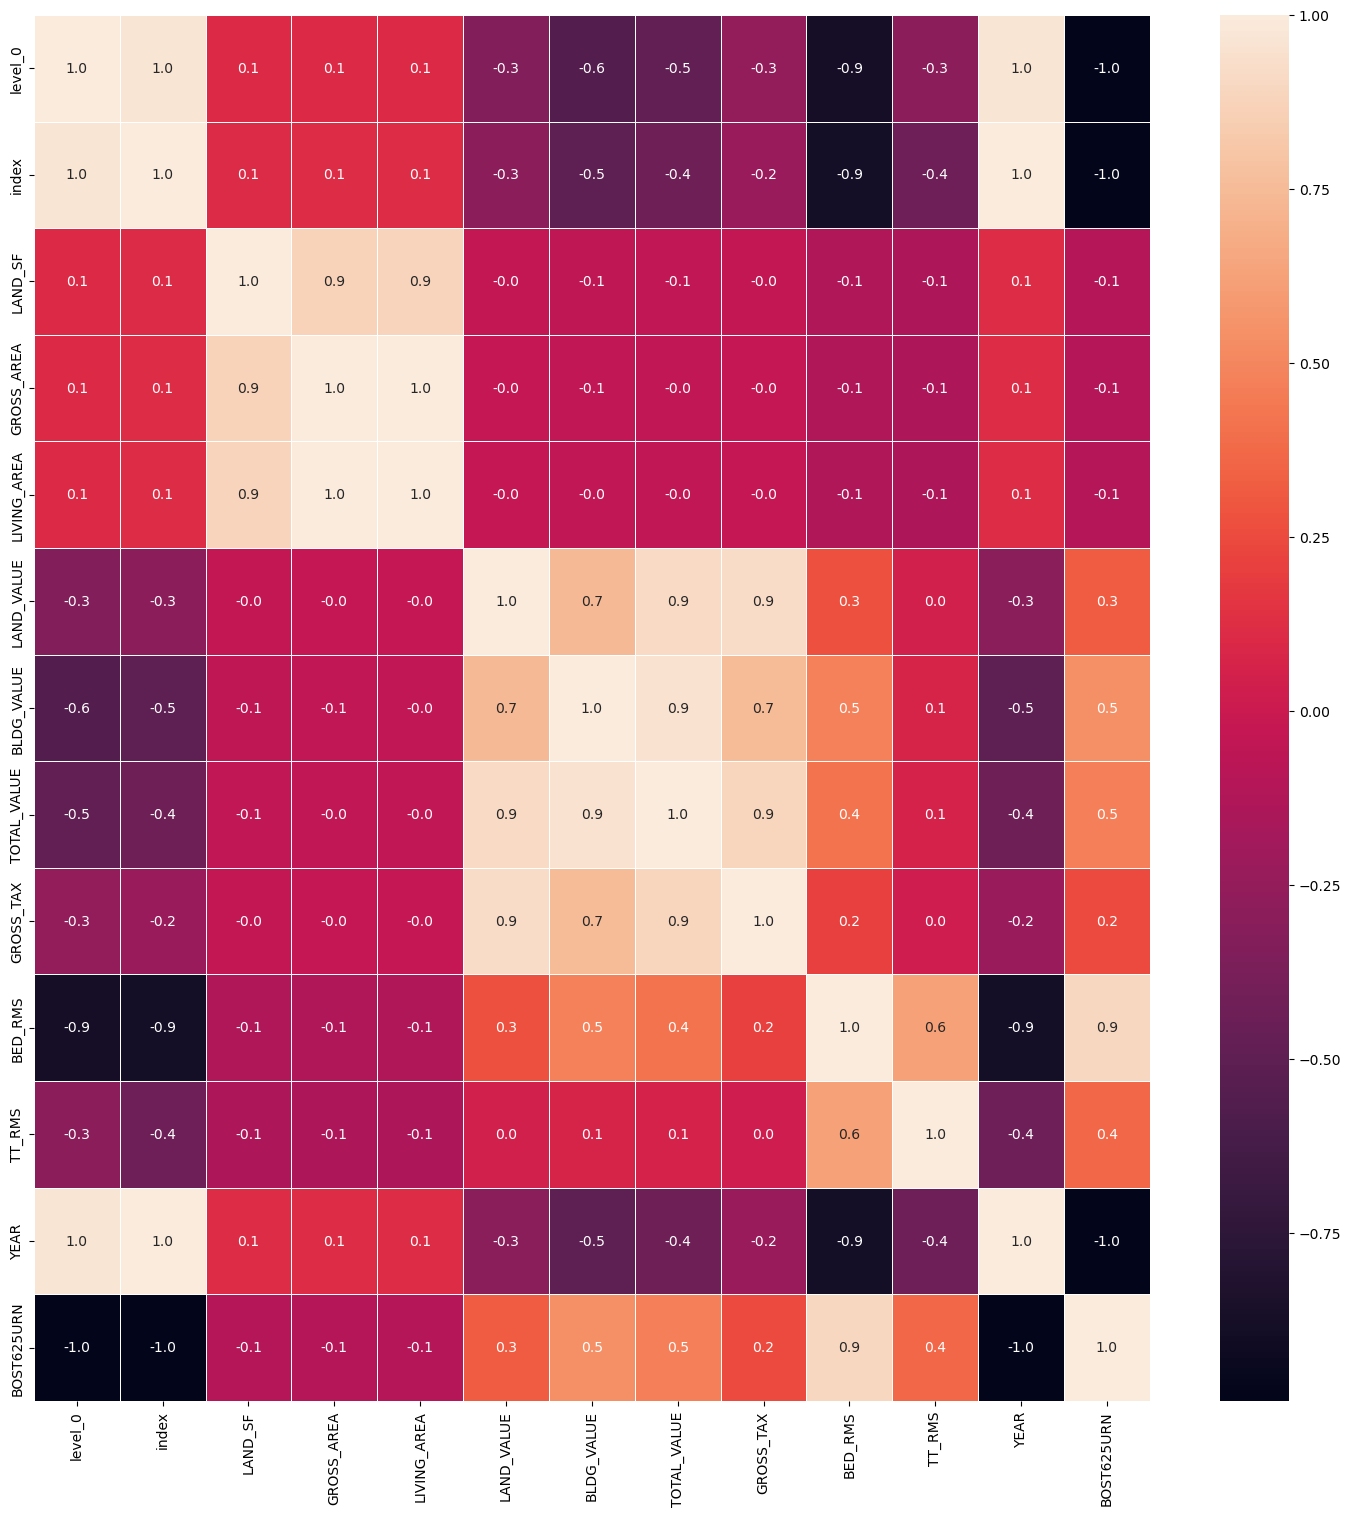

Based on the heat map, the 3 factors that affect the total value the most are GROSS_TAX, LAND_VALUE, and BLDG_VALUE
Demonstrating the relationship between GROSS_TAX, LAND_VALUE, BLDG_VALUE and TOTAL_VALUE
Model fit with Linear Regression:
1.0
Mean Squared Error: 6.580687294183747e-19
Model fit with Ridge Regression:
1.0
Mean Squared Error: 1.8701048198802813e-17
Model fit with Lasso Regression (with CV):
0.999998999365356
Mean Squared Error: 953655.1872642231

The potential renter will be a 20-22 year old college student from Northeastern University. 

According to Ziprecruiter, the average annual pay for the Student jobs category 
in Boston is $54,845 a year, or $4,570 per month, and the average living expenses 
for a student who lives off-campus is $2843 per month. With the information 
above, an average student would be able to pay a maximum of $1,727  for housing. 


The potential renter will have a budget of $1730/mo., with 2 roommates with 
similar budgets. Overall, they have a r

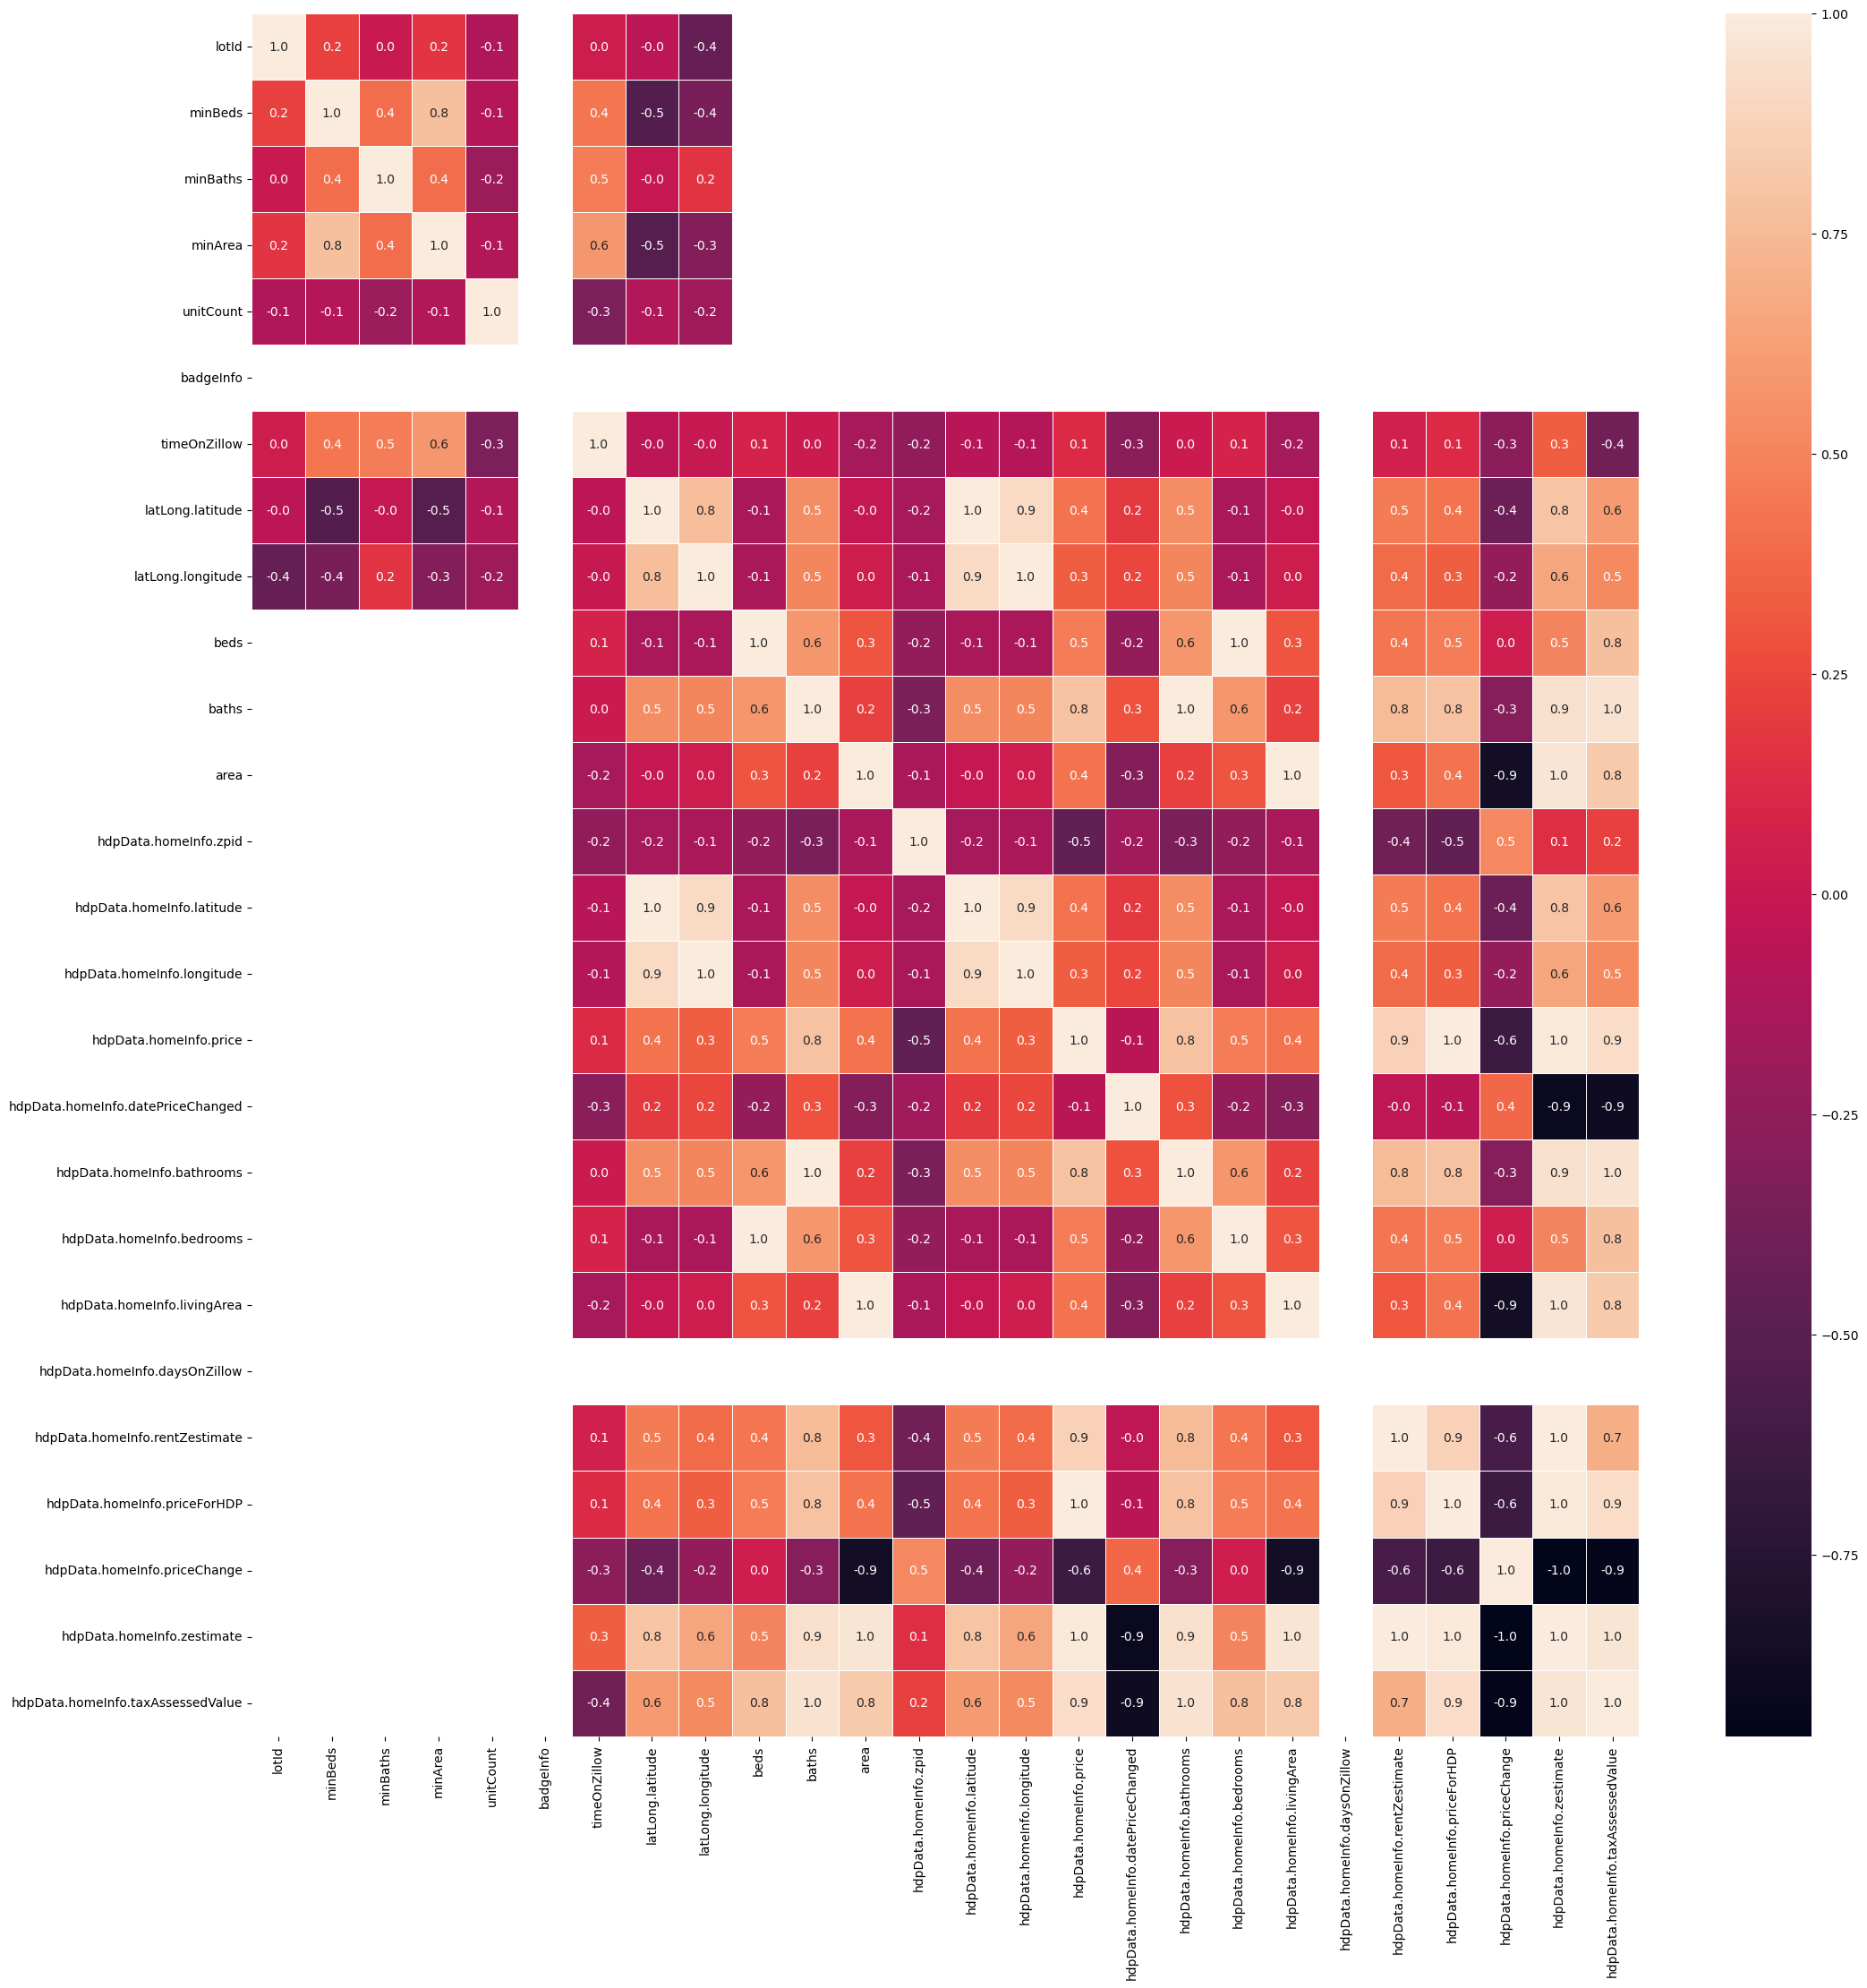

Shape of X_train, y_train:
(54, 8) (54,)
Shape of X_test, y_test:
(18, 8) (18,)

Classifying listings from Zillow with Logistic Regression:

[[6 5]
 [1 6]]
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.55      0.86      0.67         7

    accuracy                           0.67        18
   macro avg       0.70      0.70      0.67        18
weighted avg       0.74      0.67      0.67        18



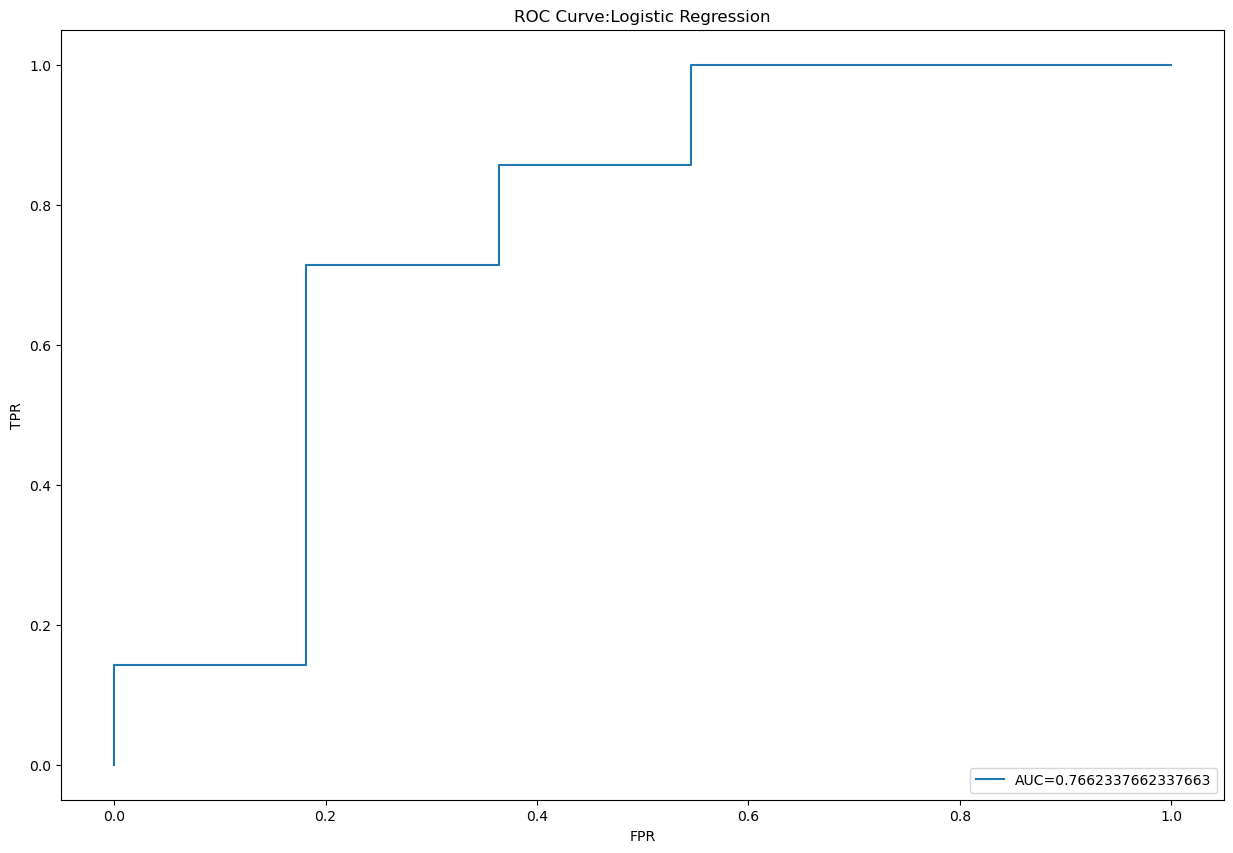

Accuracy score of the Logistic Regression model: 0.6666666666666666

Classifying listings from Zillow with Linear Discriminant Analysis:

[[4 7]
 [1 6]]
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.46      0.86      0.60         7

    accuracy                           0.56        18
   macro avg       0.63      0.61      0.55        18
weighted avg       0.67      0.56      0.54        18



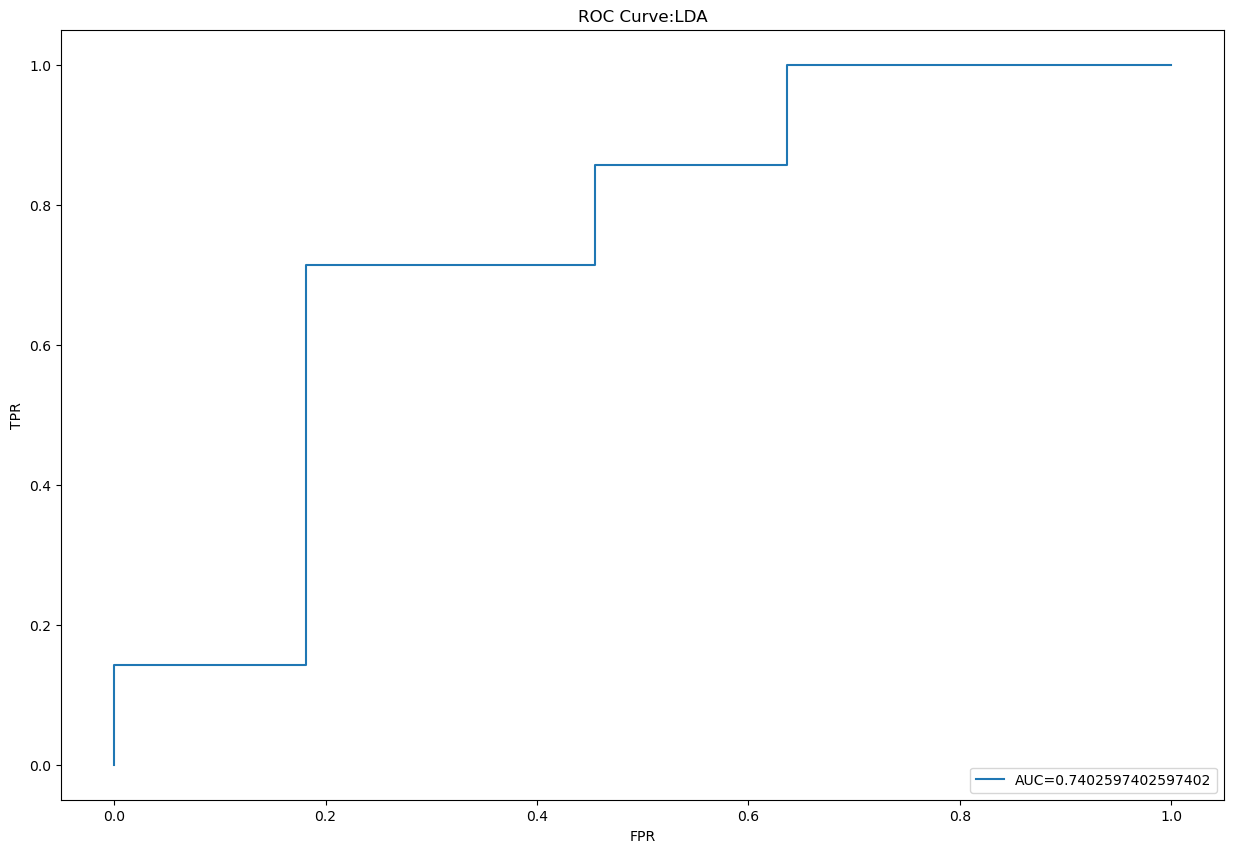

Accuracy score of the LDA model: 0.5555555555555556

Neural Network: Minibatch gradient descent and Early Stopping: 



/Users/yanglichen/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
2/2 - 1s - loss: 0.7116 - accuracy: 0.5741 - val_loss: 0.7320 - val_accuracy: 0.3889 - 1s/epoch - 534ms/step
Epoch 2/100
2/2 - 0s - loss: 0.7116 - accuracy: 0.5741 - val_loss: 0.7320 - val_accuracy: 0.3889 - 52ms/epoch - 26ms/step
Epoch 3/100
2/2 - 0s - loss: 0.7116 - accuracy: 0.5741 - val_loss: 0.7320 - val_accuracy: 0.3889 - 55ms/epoch - 27ms/step
Epoch 4/100
2/2 - 0s - loss: 0.7116 - accuracy: 0.5741 - val_loss: 0.7320 - val_accuracy: 0.3889 - 51ms/epoch - 25ms/step
Epoch 5/100
2/2 - 0s - loss: 0.7116 - accuracy: 0.5741 - val_loss: 0.7320 - val_accuracy: 0.3889 - 51ms/epoch - 25ms/step
Epoch 6/100
2/2 - 0s - loss: 0.7116 - accuracy: 0.5741 - val_loss: 0.7320 - val_accuracy: 0.3889 - 55ms/epoch - 28ms/step
Epoch 7/100
2/2 - 0s - loss: 0.7115 - accuracy: 0.5741 - val_loss: 0.7320 - val_accuracy: 0.3889 - 55ms/epoch - 27ms/step
Epoch 8/100
2/2 - 0s - loss: 0.7115 - accuracy: 0.5741 - val_loss: 0.7320 - val_accuracy: 0.3889 - 63ms/epoch - 31ms/step
Epoch 9/100
2/2 - 0s - lo

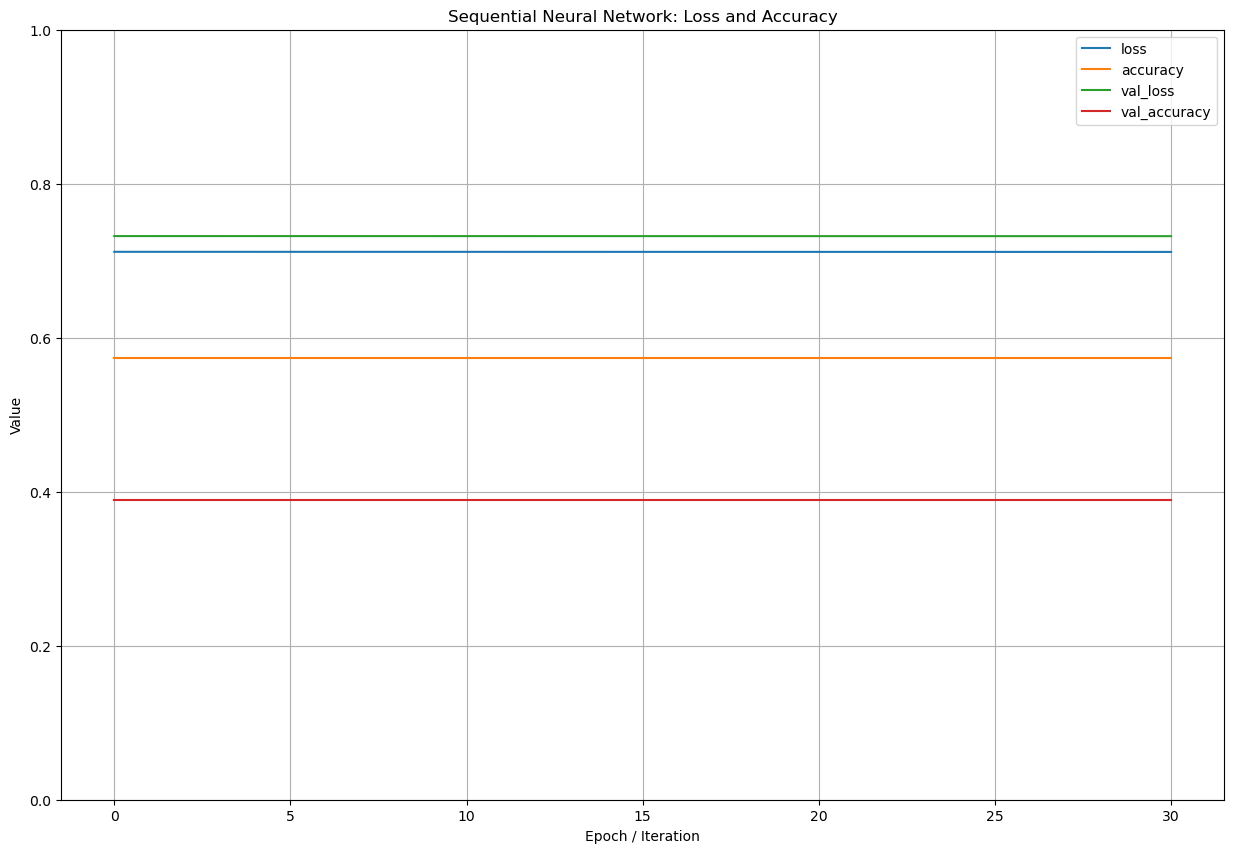

In [16]:
def main():
    
    propertydata, unemployment, bldg_violations = dataclean()
    analyzeunemployment(unemployment)
    zipcode, avgtotals = zipcodeanalysis(propertydata)
    analyzecheapest(propertydata)
    
    print(CHARACTER)
    print('\n Searching for 3 bedroom, 1+ bath properties for rent in the top 3 most affordable zipcodes:',
          avgtotals[:3])
    
    api_key = '803c12a2-d2e1-4399-81eb-7d59990547b2' # note for graders and professor Wang: This API is temporary due the user policy of Zillow, if for some reason you can not extract zillow data with this api key, please go to scrapeak.com, click on the "access to dashboard" bottom, creat an account. after that press "try for free" botton, and you should be able to your new api key under the "API and Documentation" tab. 
    listing_url = 'https://www.zillow.com/boston-ma-02108/rentals/?utm_medium=cpc&utm_source=google&utm_content=12581678795|124921361932|aud-1414479055879:kwd-315106657376|602850787172|&semQue=null&gclid=Cj0KCQjwz6ShBhCMARIsAH9A0qXwPj9BVdD3ba6PBmcep-SCxJhAIKHPo4TdJOwfGzUdAidpnKQBVKcaAoiLEALw_wcB&searchQueryState=%7B%22pagination%22%3A%7B%7D%2C%22mapBounds%22%3A%7B%22north%22%3A42.38231384608421%2C%22east%22%3A-71.02339782495118%2C%22south%22%3A42.31037709420834%2C%22west%22%3A-71.14184417504883%7D%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A58622%2C%22regionType%22%3A7%7D%2C%7B%22regionId%22%3A58629%2C%22regionType%22%3A7%7D%2C%7B%22regionId%22%3A58625%2C%22regionType%22%3A7%7D%5D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22fr%22%3A%7B%22value%22%3Atrue%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22fsbo%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%2C%22baths%22%3A%7B%22min%22%3A1%7D%2C%22beds%22%3A%7B%22min%22%3A3%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%7D'
    prices_all, listings_all = zillowdataclean(avgtotals[:3], api_key, listing_url)
    
    X_train, X_test, y_train, y_test = zillowpreprocess(listings_all, prices_all)
    
    zillowclassify(X_train, X_test, y_train, y_test)
    
    alpha = findingalpha(X_train, X_test, y_train, y_test)
    
    
    
main()